In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models
import os

In [3]:
lines = []
with open(r'/Users/rahul/Downloads/IAM_Words/words.txt') as f:
    for line in f:
        if not line.startswith("#") and line.strip():
            lines.append(line.strip())

In [4]:
# Prepare image and label arrays
images = []
labels = []
x=int(0)
for line in lines:
    splits = line.split(' ')
    status = splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = splits[-1]
        ind_folders=word_id.split('-')
        folder1=ind_folders[0]
        folder2=ind_folders[0]+'-'+ind_folders[1]
        image_path=word_id
        overal_path=folder1+'/'+folder2+'/'+image_path
        filepath=r'/Users/rahul/Downloads/IAM_Words/words/{}.png'.format(overal_path)
        if x==0:
            print('file path is ',filepath)
            x+=1
        img=filepath
        if img is not None:
            images.append(img)
            labels.append(word)

file path is  /Users/rahul/Downloads/IAM_Words/words/a01/a01-000u/a01-000u-00-00.png


In [5]:
len(images)

96456

In [6]:
len(labels)

96456

In [7]:
char_set = set()
for word in labels:
    for char in word:
        char_set.add(char)

char_list = sorted(list(char_set))
print(char_set)

{'*', 'N', 'z', 'D', 'e', 'i', 'a', 'b', '"', 'Q', '7', '1', 'F', '0', 'l', 'k', 's', 'A', 'Y', 'n', 'x', 'f', 'c', 'U', 'B', 'J', '2', 'g', 'o', 'Z', 'q', '-', '8', 'r', 'y', '5', '/', 'P', 'I', 'M', 'G', 'R', 'v', 'S', 'X', ')', '4', '.', 'p', '#', 'O', 'm', '9', 'H', 'C', 'E', 'V', 'W', ';', '6', 'u', ',', 'K', '+', '3', ':', '(', 't', 'j', 'L', 'T', '!', "'", '?', 'w', '&', 'd', 'h'}


In [8]:
for word in labels:
    if word.count(' ') > 0:
        print(word)

In [9]:
max_label_len=0
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
    return dig_lst


In [10]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255
    return img

img is  [[249 249 246 ... 251 251 251]
 [250 249 231 ... 251 251 251]
 [245 241 216 ... 251 251 251]
 ...
 [123 202 234 ...  94 194 233]
 [142 218 240 ... 158 230 241]
 [163 233 241 ... 221 237 242]]
[Powell]
[more]


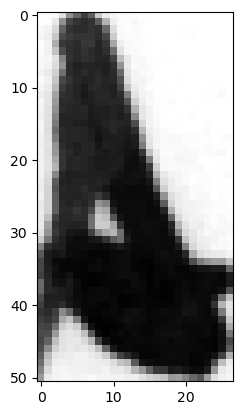

In [11]:
import matplotlib.pyplot as plt
max_label_len = 0
all_images = []
all_labels = []
all_input_length = []
label_length = []
original_text = []
x=0
for line in lines:
    splits = line.split(' ')
    status = splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = splits[-1]
        ind_folders=word_id.split('-')
        folder1=ind_folders[0]
        folder2=ind_folders[0]+'-'+ind_folders[1]
        image_path=word_id
        overal_path=folder1+'/'+folder2+'/'+image_path
        filepath=r'/Users/rahul/Downloads/IAM_Words/words/{}.png'.format(overal_path)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if x==0:
            plt.imshow(img,cmap='gray')
            print('img is ',img)
            x+=1
        try:
            img = process_image(img)
            label = encode_to_labels(word)
        #print(label)
        except:
            print(f"[{word}]")
            continue
        all_images.append(img)
        all_labels.append(label)
        all_input_length.append(31)
        label_length.append(len(word))
        original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

In [12]:
img2=cv2.imread('/Users/rahul/Downloads/IAM_Words/words/a01/a01-000u/a01-000u-00-00.png',cv2.IMREAD_GRAYSCALE)
print(img2)

[[249 249 246 ... 251 251 251]
 [250 249 231 ... 251 251 251]
 [245 241 216 ... 251 251 251]
 ...
 [123 202 234 ...  94 194 233]
 [142 218 240 ... 158 230 241]
 [163 233 241 ... 221 237 242]]


In [13]:
print(all_images[1].size)

4096


In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
padded_labels = pad_sequences(all_labels, maxlen=max_label_len, padding='post')
padded_labels = np.asarray(padded_labels)

In [16]:
train_size = 0.85

split_index = int(len(all_images) * 0.85)
train_images = np.array(all_images[:split_index])
valid_images = np.array(all_images[split_index:])

train_padded_label = np.array(padded_labels[:split_index])
valid_padded_label = np.array(padded_labels[split_index:])

train_input_length = np.array(all_input_length[:split_index])
valid_input_length = np.array(all_input_length[split_index:])

train_label_length = np.array(label_length[:split_index])
valid_label_length = np.array(label_length[split_index:])

train_original_text = np.array(original_text[:split_index])
valid_original_text = np.array(original_text[split_index:])

In [17]:
train_padded_label.shape, valid_padded_label.shape, max_label_len

((81985, 21), (14469, 21), 21)

In [18]:
train_images.shape, valid_images.shape, train_input_length.shape, valid_input_length.shape, train_label_length.shape, valid_label_length.shape,train_original_text.shape,valid_original_text.shape

((81985, 32, 128, 1),
 (14469, 32, 128, 1),
 (81985,),
 (14469,),
 (81985,),
 (14469,),
 (81985,),
 (14469,))

In [19]:
train_images[0].shape

(32, 128, 1)

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Bidirectional, LSTM, MaxPool2D, Input, Lambda
#from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [36]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 16, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 8, 32, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 32, 256)        295168

In [47]:
from keras.layers import Input, Conv2D, MaxPool2D, LSTM, Bidirectional, Dense, Lambda
from keras.models import Model

inputs = Input(shape=(32,128,1))

# Reduce the number of filters in convolutional layers
conv_1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

# Remove conv_3, conv_4, and corresponding pooling layers
# conv_3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_2)
# pool_3 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_3)

# conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_3)
# pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

# Remove the rest of the convolutional layers
# conv_5 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_4)

# conv_6 = Conv2D(256, (3,3), activation='relu', padding='same')(conv_5)
# pool_6 = MaxPool2D(pool_size=(2, 1))(conv_6)

# conv_7 = Conv2D(256, (2,2), activation='relu')(pool_6)

# Use only one convolutional layer before LSTM
conv_3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_2)
batch_norm_3 = BatchNormalization()(conv_3)
pool_3 = MaxPool2D(pool_size=(2, 1))(batch_norm_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(pool_3)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_4)

print("Shape of pool_3:", conv_7.shape)


squeezed = Lambda(lambda x: K.squeeze(x, axis=1))(conv_7)


# Use bidirectional LSTM
blstm_1 = Bidirectional(LSTM(256, return_sequences=True,dropout=0.2))(squeezed)

outputs = Dense(len(char_list)+1, activation='softmax')(blstm_1)

act_model = Model(inputs, outputs)
act_model.summary()

Shape of pool_3: (None, 1, 31, 512)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_88 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_90 (MaxPooli  (None, 16, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 16, 64, 64)        18496     
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 8, 32, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)    

In [48]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int8')
label_length = Input(name='label_length', shape=[1], dtype='int8')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [68]:
batch_size = 8
epochs = 10
e = str(epochs)
optimizer = 'adam'

In [69]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
filepath="{}o-{}e-{}t-{}v.hdf5".format(optimizer,
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
with open('/Users/rahul/Downloads/IAM_Words/model.json', 'w') as f:
    f.write(model.to_json())
f.close()

In [70]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1)

Epoch 1/10
10249/10249 [==============================] - 1179s 115ms/step - loss: 2.6060 - accuracy: 0.4245 - val_loss: 2.3259 - val_accuracy: 0.4761
Epoch 2/10
10249/10249 [==============================] - 1345s 131ms/step - loss: 2.1596 - accuracy: 0.4862 - val_loss: 2.1356 - val_accuracy: 0.5075
Epoch 3/10
10249/10249 [==============================] - 2088s 204ms/step - loss: 1.8649 - accuracy: 0.5327 - val_loss: 1.9938 - val_accuracy: 0.5403
Epoch 4/10
10249/10249 [==============================] - 1070s 104ms/step - loss: 1.6435 - accuracy: 0.5676 - val_loss: 1.9629 - val_accuracy: 0.5750
Epoch 5/10
10249/10249 [==============================] - 1232s 120ms/step - loss: 1.4646 - accuracy: 0.5975 - val_loss: 1.8426 - val_accuracy: 0.5862
Epoch 6/10
10249/10249 [==============================] - 1272s 124ms/step - loss: 1.3107 - accuracy: 0.6273 - val_loss: 1.7938 - val_accuracy: 0.6065
Epoch 7/10
10249/10249 [==============================] - 1244s 121ms/step - loss: 1.2009 - ac

1/1 [==============================] - 0s 58ms/step
original_text =   that
predicted text = that

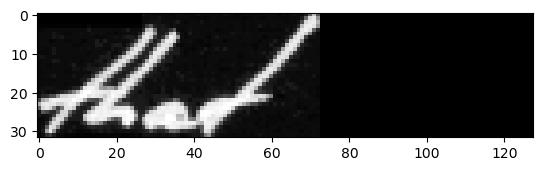



original_text =   Labour
predicted text = Labour

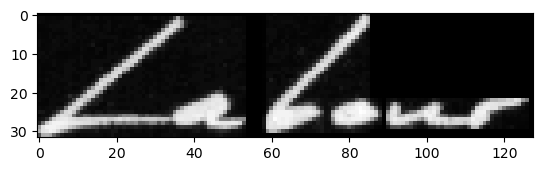



original_text =   should
predicted text = stould

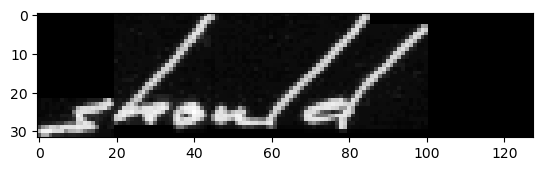



original_text =   not
predicted text = not

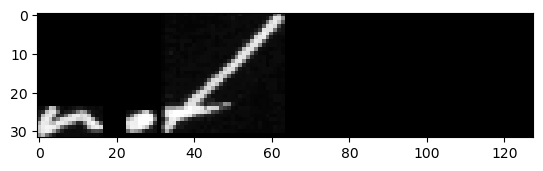



original_text =   take
predicted text = take

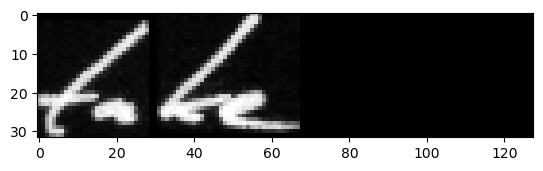



original_text =   any
predicted text = any

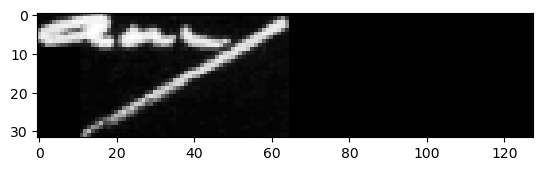



original_text =   steps
predicted text = stepr

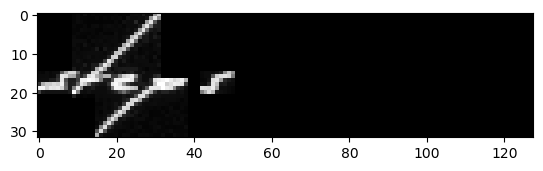



original_text =   institution
predicted text = institutioa

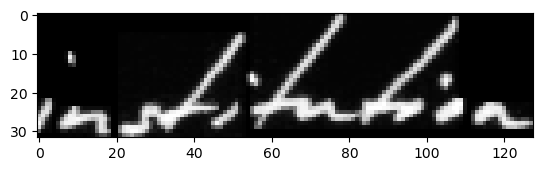



original_text =   .
predicted text = .

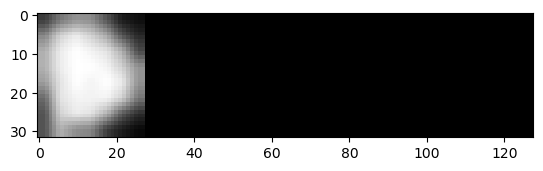



original_text =   Though
predicted text = Though

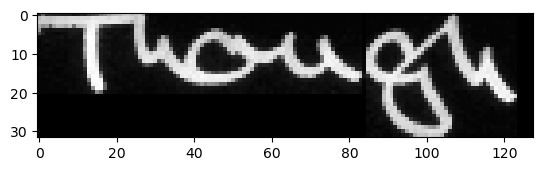



original_text =   they
predicted text = they

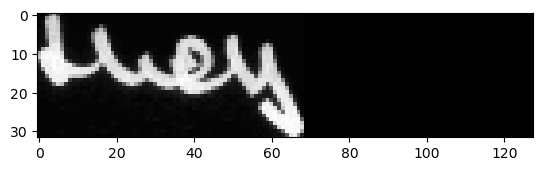



original_text =   may
predicted text = may

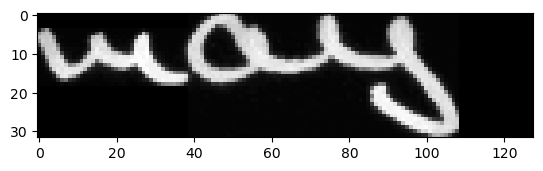



original_text =   gather
predicted text = gather

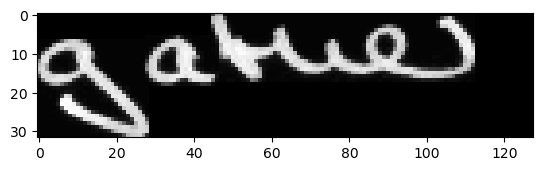



original_text =   some
predicted text = some

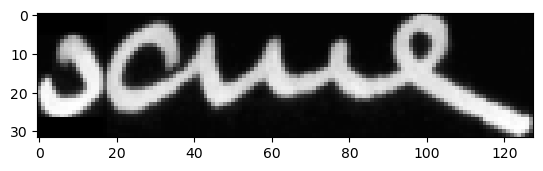



original_text =   Left-wing
predicted text = Left-wing

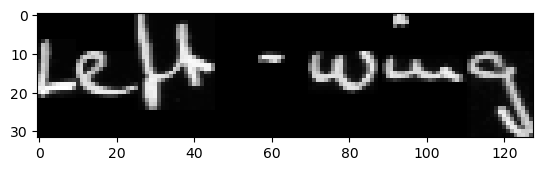



original_text =   support
predicted text = support

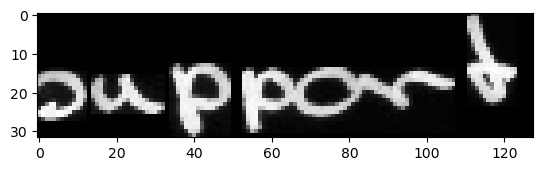



original_text =   ,
predicted text = ,

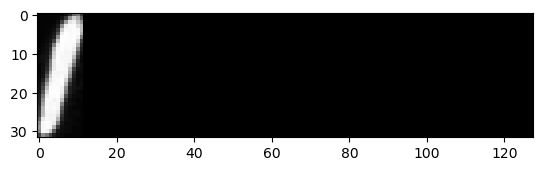



original_text =   a
predicted text = a

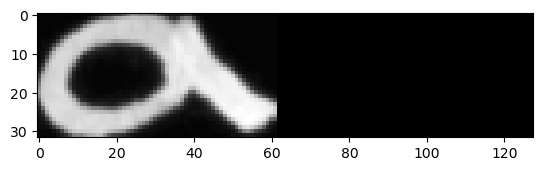



original_text =   large
predicted text = large

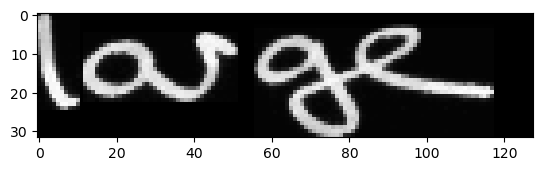



original_text =   majority
predicted text = majority

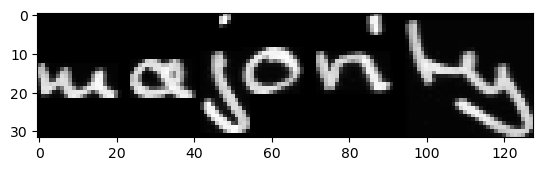

In [87]:
# predict outputs on validation images
prediction = act_model.predict(train_images[150:170])

# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[150+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()

    print('\n')

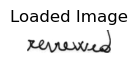

In [72]:
import cv2
import matplotlib.pyplot as plt

# Path to the image
img_path_100 = '/Users/rahul/Downloads/IAM_Words/words/a04/a04-000/a04-000-00-02.png'

# Load the image in grayscale
predictable_img = cv2.imread(img_path_100, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if predictable_img is None:
    print(f"Error: Unable to load image at {img_path_100}")
else:
    # Display the image
    plt.imshow(predictable_img, cmap='gray')
    plt.title('Loaded Image')
    plt.axis('off')  # Hide axes
    ax = plt.subplot(111)
    ax.set_position([0.02, 0.02, 0.13, 0.2])
    plt.show()


In [73]:
predictable_array_images=[]
predictable_img2 = process_image(predictable_img)
predictable_array_images.append(predictable_img2)
print(predictable_array_images[0].shape)
bimbon_images = np.array(predictable_array_images[:split_index])
bimbon_images = tf.expand_dims(bimbon_images, axis=0)
print(bimbon_images[0].shape)

(32, 128, 1)
(1, 32, 128, 1)


1/1 [==============================] - 0s 22ms/step
[[[3.8357941e-12 4.1295606e-10 7.1047616e-06 ... 1.1622580e-07
   3.7433355e-04 5.9516380e-05]
  [1.0046429e-21 1.4442005e-19 2.5476244e-16 ... 2.9018933e-11
   1.3319023e-11 9.9958462e-01]
  [1.0655092e-26 3.5232087e-18 2.1498243e-14 ... 2.4068744e-12
   8.7314562e-15 9.9999714e-01]
  ...
  [1.1136745e-18 1.2461853e-12 2.5730160e-18 ... 4.4591606e-09
   9.1112025e-13 9.9996996e-01]
  [1.1722266e-20 1.0017283e-15 4.1159089e-20 ... 1.2359731e-09
   7.6261883e-15 9.9999869e-01]
  [3.4173610e-18 9.4678941e-13 3.3870194e-17 ... 3.0116512e-09
   5.8894784e-13 9.9998832e-01]]]
out is  [[69 56 64 56 74 56 55 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1]]
predicted text = remewed

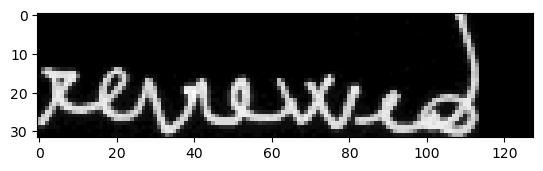

In [86]:
# predict outputs on validation images
prediction = act_model.predict(bimbon_images[0])

print(prediction)

# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)
print('out is ',out)

for i, x in enumerate(out):
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    new_shape = (32, 128)  # Example new shape
    reshaped_tensor = tf.reshape(bimbon_images[0], new_shape)
    plt.imshow(reshaped_tensor,cmap=plt.cm.gray)
    plt.show()

    print('\n')

In [83]:
model.save('/Users/rahul/Downloads/IAM_Words/my_model_22ndmay512pm.h5')

In [75]:
import pickle

In [ ]:
with open('/Users/rahul/Downloads/IAM_Words/model_pickle','wb') as f:
    pickle.dump(model,f)

In [76]:
import joblib

In [77]:
joblib.dump(act_model,'/Users/rahul/Downloads/IAM_Words/act_model__joblib_10_epochs')

['/Users/rahul/Downloads/IAM_Words/act_model__joblib_10_epochs']

In [85]:
from tensorflow.keras.models import load_model

# Load the model (if previously saved)
model = load_model('/Users/rahul/Downloads/IAM_Words/my_model_22ndmay512pm.h5',custom_objects={'custom_loss_function': custom_loss_function})


NameError: name 'custom_loss_function' is not defined